In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OWord2vecEstimator

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18 LTS; OpenJDK Runtime Environment Microsoft-6841889 (build 11.0.17+8-LTS); OpenJDK 64-Bit Server VM Microsoft-6841889 (build 11.0.17+8-LTS, mixed mode)
  Starting server from /Users/mathanraj/miniconda3-intel/envs/h2o-automl-ieee/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zj/gwq9z5vn0tz1w2vrj049st180000gn/T/tmp2z97xob1
  JVM stdout: /var/folders/zj/gwq9z5vn0tz1w2vrj049st180000gn/T/tmp2z97xob1/h2o_mathanraj_started_from_python.out
  JVM stderr: /var/folders/zj/gwq9z5vn0tz1w2vrj049st180000gn/T/tmp2z97xob1/h2o_mathanraj_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Colombo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_mathanraj_s7aa2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
# Import the craigslist dataset into H2O:
job_titles = h2o.import_file(
    ("https://s3.amazonaws.com/h2o-public-test-data/smalldata/craigslistJobTitles.csv"),
    col_names = ["category", "jobtitle"],
    col_types = ["string", "string"],
    header = 1
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
STOP_WORDS = [
    "ax","i","you","edu","s","t","m","subject","can",
    "lines","re","what","there","all","we","one","the",
    "a","an","of","or","in","for","by","on","but","is",
    "in","a","not","with","as","was","if","they","are",
    "this","and","it","have","from","at","my","be","by",
    "not","that","to","from","com","org","like","likes",
    "so"
]

In [5]:
# Make the 'tokenize' function:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]", invert=True, output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [6]:
# Make the `predict` function:
def predict(job_title, w2v, gbm):
    words = tokenize(h2o.H2OFrame(job_title).ascharacter())
    job_title_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(gbm.predict(test_data=job_title_vec))

In [7]:
# Break job titles into a sequence of words:
words = tokenize(job_titles["jobtitle"])

# Build word2vec model:
w2v_model = H2OWord2vecEstimator(
    sent_sample_rate=0.0, 
    epochs=10
)
w2v_model.train(training_frame=words)

# Find synonyms for the words "teacher":
w2v_model.find_synonyms("teacher", count = 5)

word2vec Model Build progress: |█████████████████████████████████████████████████| (done) 100%


OrderedDict([('preschool', 0.6803655624389648),
             ('infant', 0.6537371873855591),
             ('teaching', 0.6440338492393494),
             ('aide', 0.6299718618392944),
             ('toddler', 0.6294752955436707)])

In [8]:
# Calculate a vector for each job title:
job_title_vecs = w2v_model.transform(words, aggregate_method="AVERAGE")

# Prepare training & validation data (keep only job titles made of known words):
valid_job_titles = ~job_title_vecs["C1"].isna()
job_titles["category"] = job_titles["category"].asfactor()
data = job_titles[valid_job_titles, :].cbind(job_title_vecs[valid_job_titles, :])

train, valid, test = data.split_frame(ratios=[0.7, 0.2])

In [9]:
# Build a AutoML model:
aml = H2OAutoML(
    nfolds=5,
    max_models=5,
    max_runtime_secs=300, 
    seed=1234
)

aml.train(x=job_title_vecs.names ,y="category", training_frame=train, validation_frame=valid)

AutoML progress: |
20:04:59.468: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:04:59.474: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),3/3
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [10]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230712_200459,0.195231,0.556729,0.420067,0.176456
StackedEnsemble_BestOfFamily_1_AutoML_1_20230712_200459,0.197727,0.560568,0.421401,0.177579
GBM_1_AutoML_1_20230712_200459,0.203024,0.567833,0.416791,0.173715
DRF_1_AutoML_1_20230712_200459,0.205205,0.793905,0.450146,0.202631
GBM_2_AutoML_1_20230712_200459,0.206565,0.586845,0.424963,0.180594
GBM_3_AutoML_1_20230712_200459,0.206675,0.594006,0.426355,0.181779
GLM_1_AutoML_1_20230712_200459,0.222568,0.659705,0.448663,0.201298


In [11]:
best_model = aml.get_best_model()

In [12]:
# Predict
print(predict(["school teacher having holidays every month"], w2v_model, best_model))
print(predict(["developer with 3+ Java experience, jumping"], w2v_model, best_model))
print(predict(["Financial accountant CPA preferred"], w2v_model, best_model))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
predict      accounting    administrative    customerservice    education    foodbeverage       labor
education   0.000229238        0.00979087         0.00588559     0.979767      0.00081764  0.00350966
[1 row x 7 columns]

None
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
predict           accounting    administrative    customerservice    education    foodbeverage     labor
administrative     0.0540014          0.304261           0.297993    0.0445497       0.0989893  0.200205
[1 row x 7 columns]

None
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |█████████████████████

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230712_200459

accounting,administrative,customerservice,education,foodbeverage,labor,Error,Rate
134.0,11.0,2.0,1.0,1.0,0.0,0.1006711,15 / 149
6.0,197.0,24.0,5.0,5.0,9.0,0.1991870,49 / 246
5.0,22.0,165.0,9.0,12.0,21.0,0.2948718,69 / 234
0.0,4.0,2.0,220.0,1.0,2.0,0.0393013,9 / 229
0.0,5.0,14.0,3.0,204.0,24.0,0.184,46 / 250
1.0,5.0,21.0,5.0,12.0,208.0,0.1746032,44 / 252
146.0,244.0,228.0,243.0,235.0,264.0,0.1705882,"232 / 1,360"


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

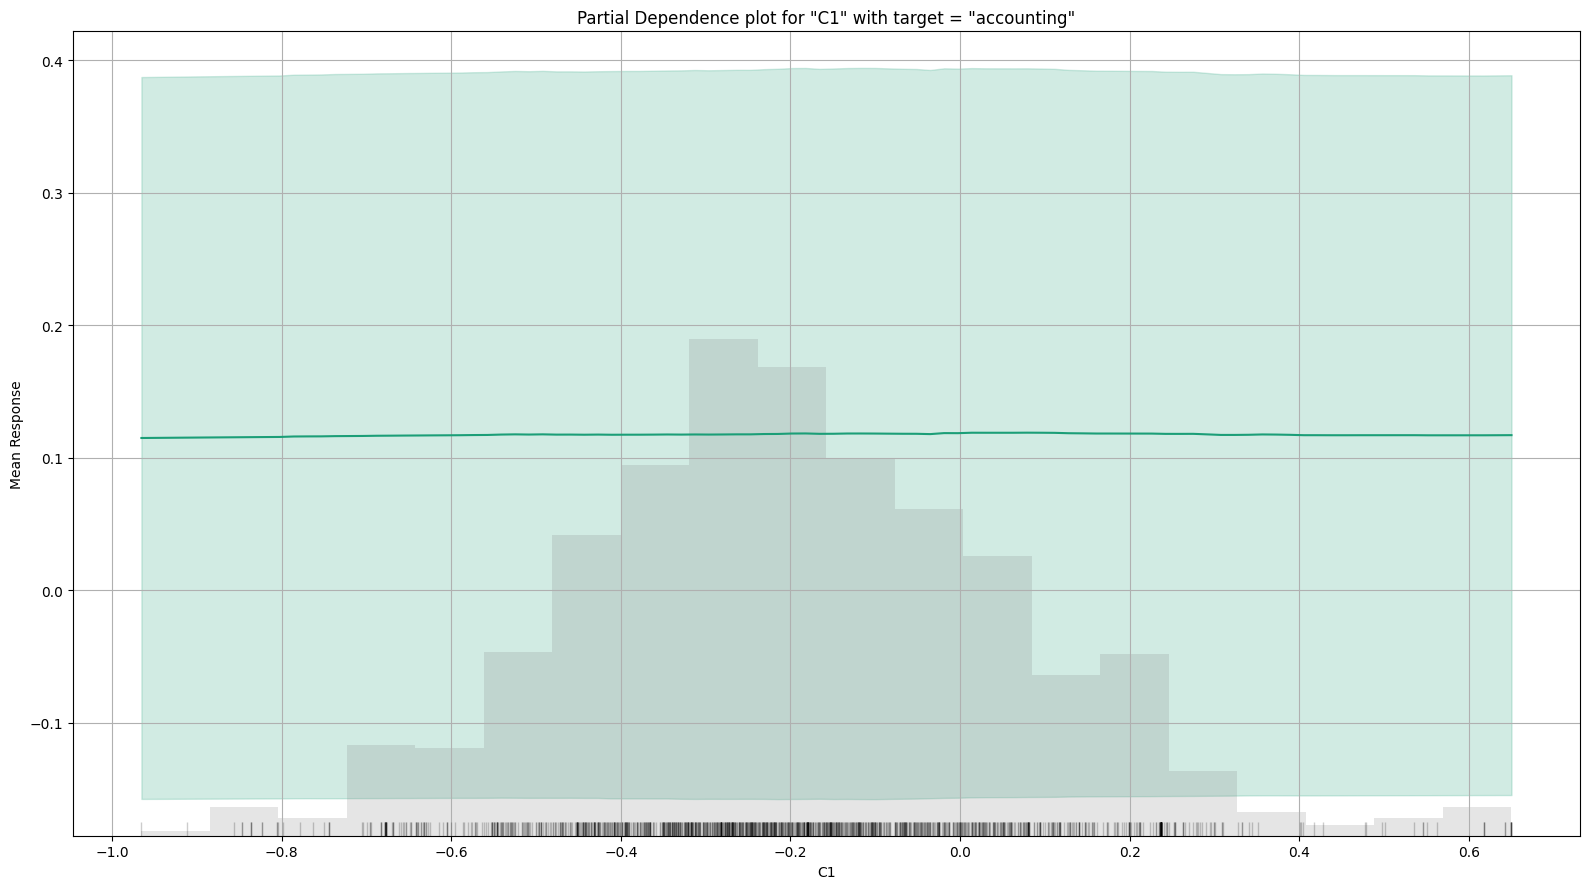

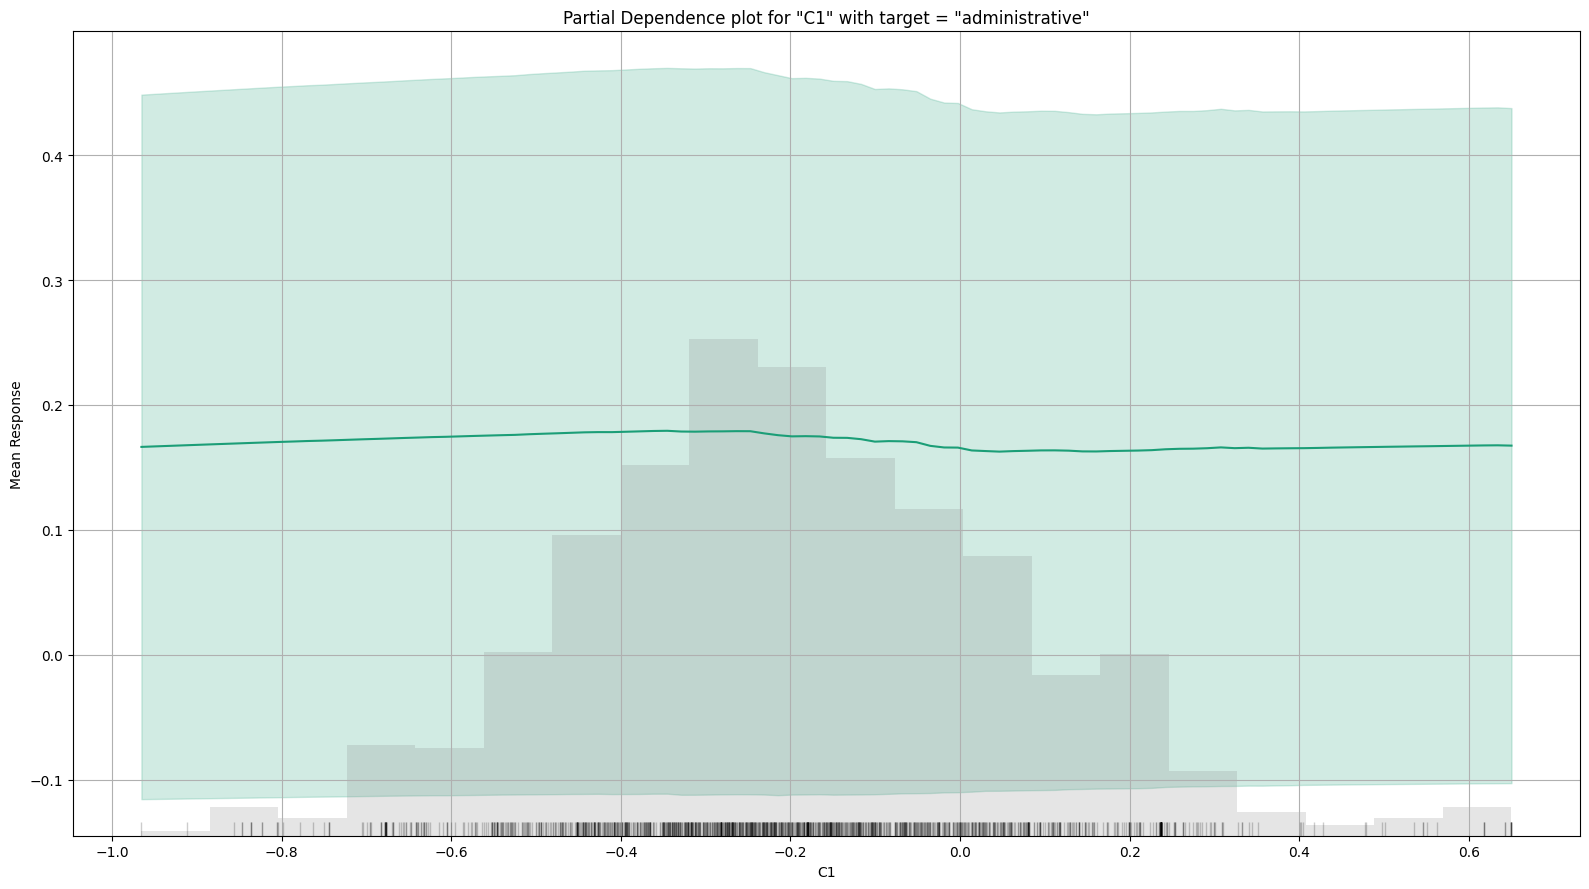

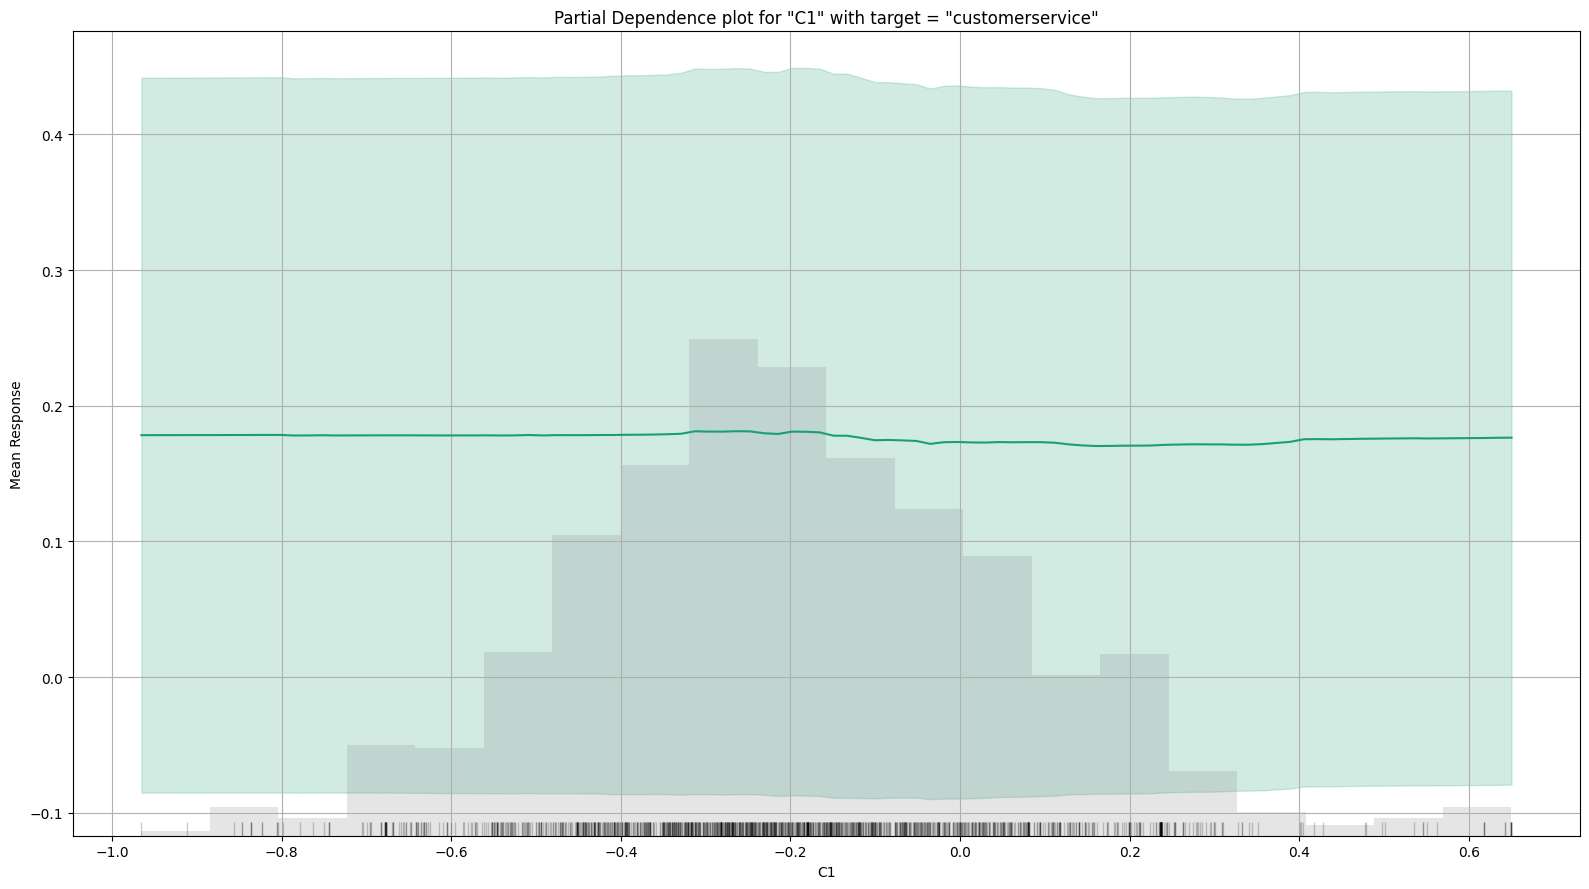

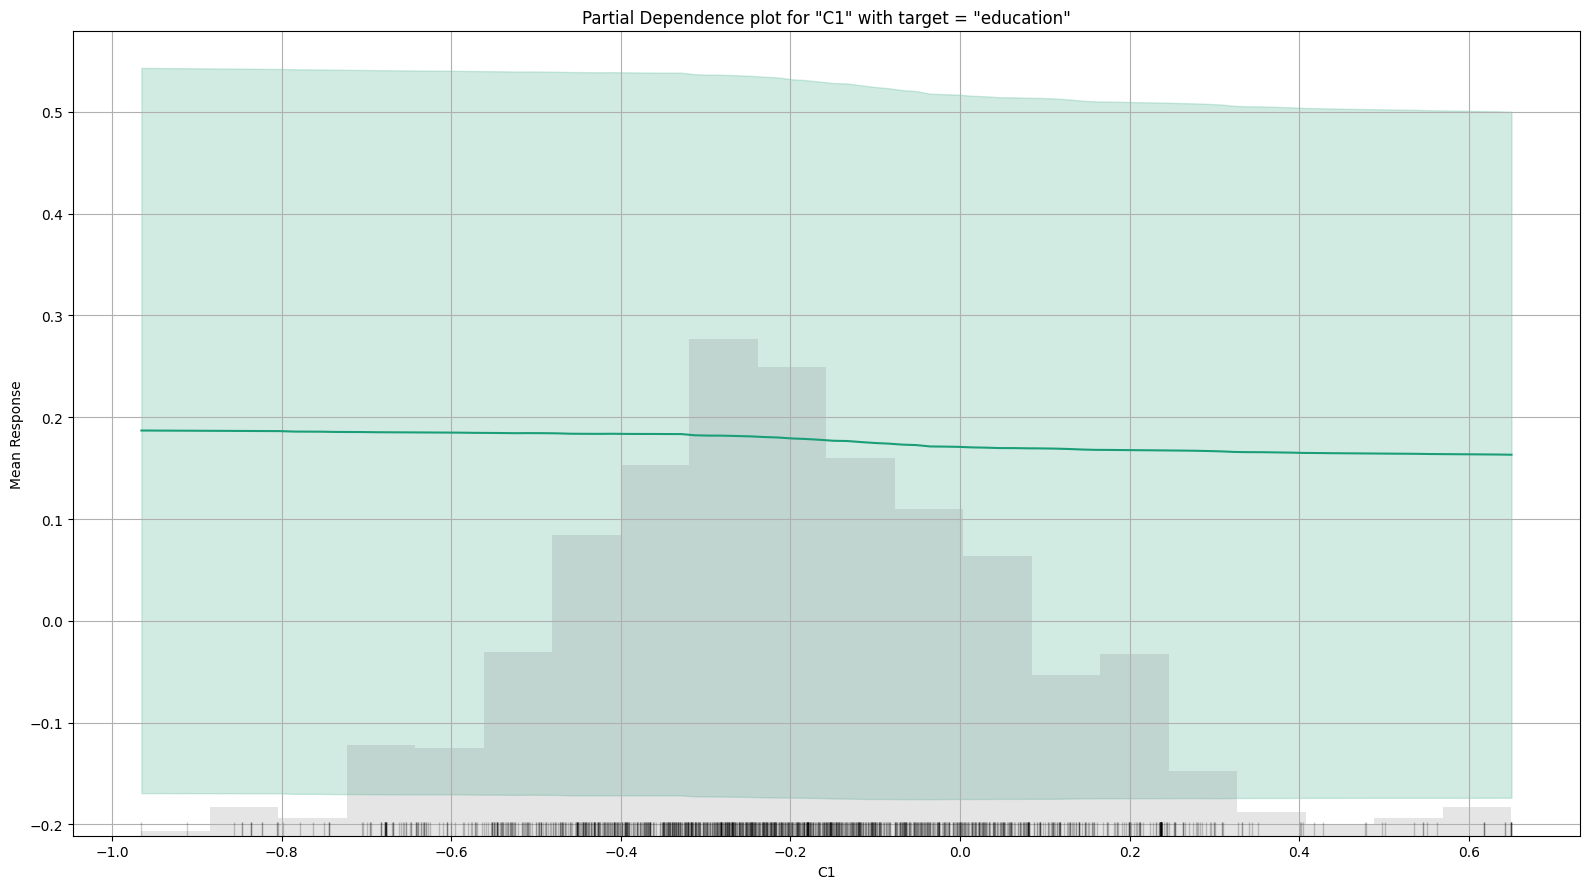

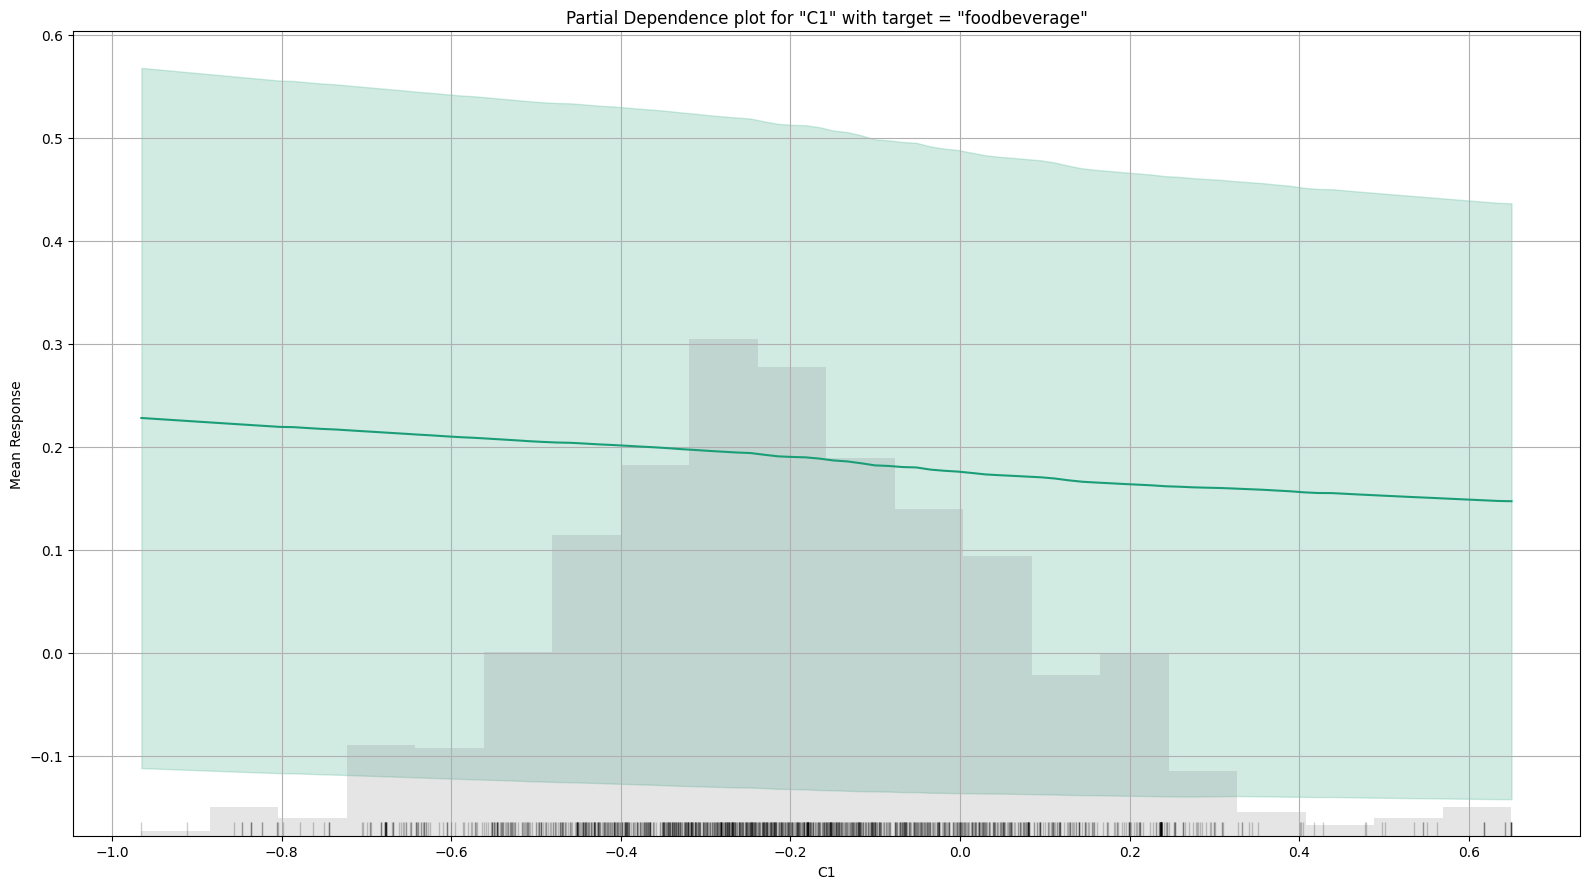

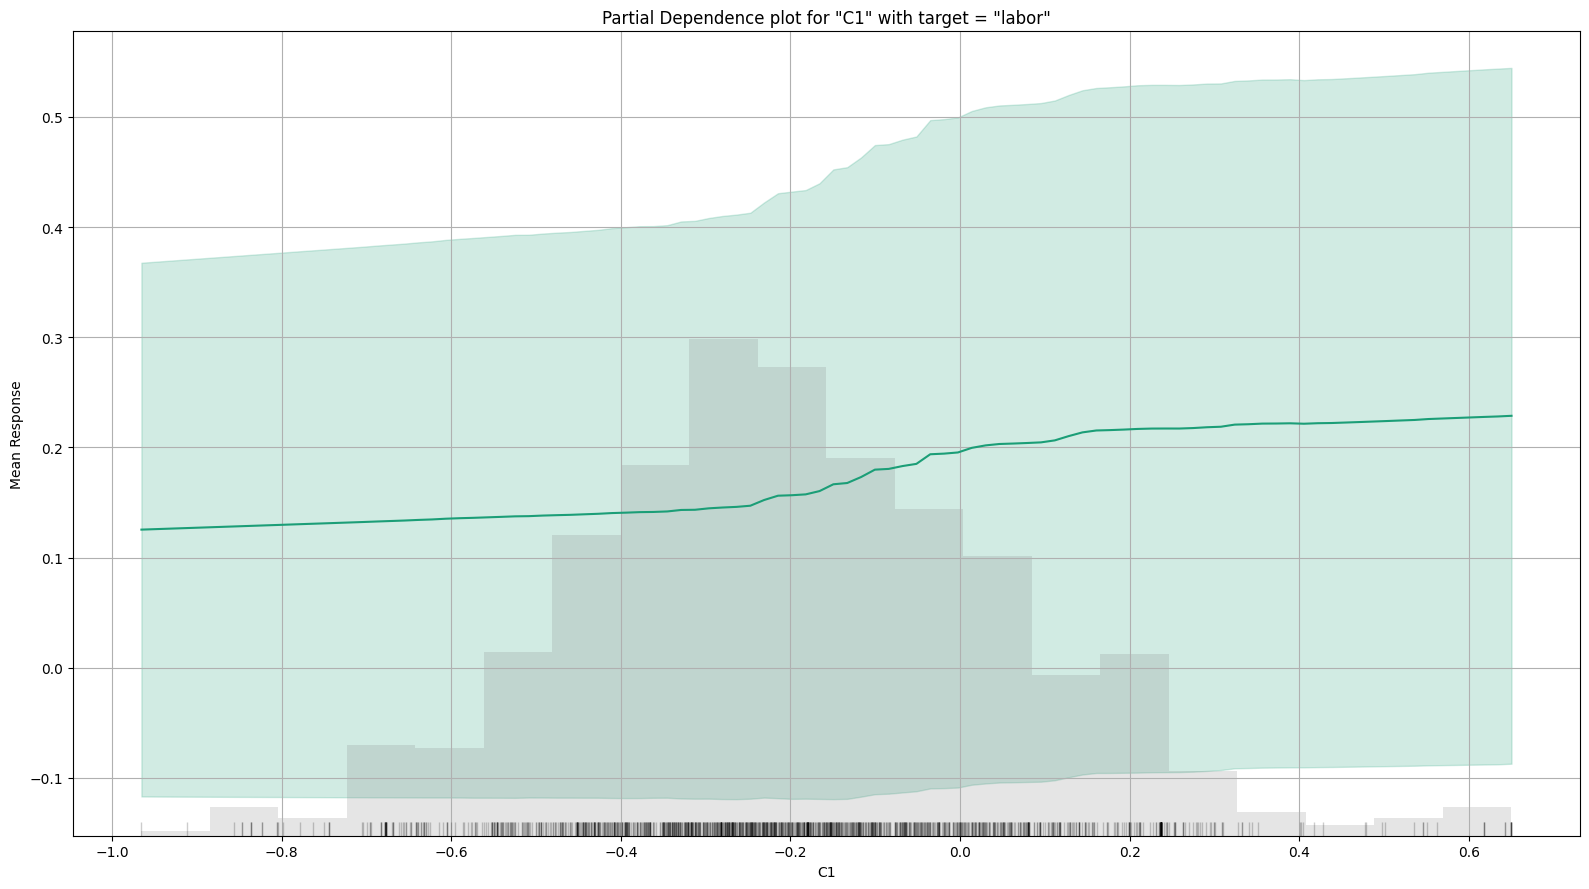

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230712_200459

accounting,administrative,customerservice,education,foodbeverage,labor,Error,Rate
134.0,11.0,2.0,1.0,1.0,0.0,0.1006711,15 / 149
6.0,197.0,24.0,5.0,5.0,9.0,0.1991870,49 / 246
5.0,22.0,165.0,9.0,12.0,21.0,0.2948718,69 / 234
0.0,4.0,2.0,220.0,1.0,2.0,0.0393013,9 / 229
0.0,5.0,14.0,3.0,204.0,24.0,0.184,46 / 250
1.0,5.0,21.0,5.0,12.0,208.0,0.1746032,44 / 252
146.0,244.0,228.0,243.0,235.0,264.0,0.1705882,"232 / 1,360"


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [13]:
best_model.explain(test, columns=["C1"], exclude_explanations=["learning_curve"])